<a href="https://colab.research.google.com/github/skozh/ComputerVision/blob/master/gan_faces_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
from __future__ import division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
import time
import os

Today we are going to train GAN for generating faces and then we will make fun playing with it. Generative adversarial networks (GANs) are deep neural net architectures comprised of two nets, pitting one against the other (thus the “adversarial”). One neural network, called the generator, generates new faces, while the other, the discriminator,  decides whether each instance of face it reviews belongs to the actual training dataset or not.

Firstly download aligned faces of celebrities from here <a href="https://yadi.sk/d/xjuClJJH3MAVXh">link</a> and extract them into folder near ipython notebook.

In [ ]:
# Original Version: Taehoon Kim (http://carpedm20.github.io)
#   + Source: https://github.com/carpedm20/DCGAN-tensorflow/blob/e30539fb5e20d5a0fed40935853da97e9e55eee8/utils.py
#   + License: MIT
from __future__ import division
import math
import random
#import scipy.misc
import imageio
import numpy as np

def get_image(image_path, image_size, is_crop=True):
    return transform(imread(image_path), image_size, is_crop)

def save_images(images, size, image_path):
    return imsave(inverse_transform(images), size, image_path)

def imread(path):
    return scipy.misc.imread(path).astype(np.float)

def merge_images(images, size):
    return inverse_transform(images)

def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((int(h * size[0]), int(w * size[1]), 3))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w, :] = image
    return img

def imsave(images, size, path):
    img = merge(images, size)
    return imageio.imwrite(path, (255*img).astype(np.uint8))

def transform(image, npx=64, is_crop=True):
    return np.array(image)/127.5 - 1.

def inverse_transform(images):
    return (images+1.)/2.

In [ ]:
# Original Version: Taehoon Kim (http://carpedm20.github.io)
#   + Source: https://github.com/carpedm20/DCGAN-tensorflow/blob/e30539fb5e20d5a0fed40935853da97e9e55eee8/ops.py
#   + License: MIT

import math
import numpy as np
import tensorflow as tf

class batch_norm(object):
    """Code modification of http://stackoverflow.com/a/33950177"""
    def __init__(self, epsilon=1e-5, momentum = 0.9, name="batch_norm"):
        with tf.variable_scope(name):
            self.epsilon = epsilon
            self.momentum = momentum

            self.name = name

    def __call__(self, x, train=True):
        return tf.contrib.layers.batch_norm(x, decay=self.momentum, updates_collections=None, epsilon=self.epsilon,
                                            center=True, scale=True, is_training=train, scope=self.name)

def conv2d(input_, output_dim,
           k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02,
           name="conv2d"):
    with tf.variable_scope(name):
        w = tf.get_variable('w', [k_h, k_w, input_.get_shape()[-1], output_dim],
                            initializer=tf.truncated_normal_initializer(stddev=stddev))
        conv = tf.nn.conv2d(input_, w, strides=[1, d_h, d_w, 1], padding='SAME')

        biases = tf.get_variable('biases', [output_dim], initializer=tf.constant_initializer(0.0))
        # conv = tf.reshape(tf.nn.bias_add(conv, biases), conv.get_shape())
        conv = tf.nn.bias_add(conv, biases)

        return conv

def lrelu(x, leak=0.2, name="lrelu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)
    
def deconv2d(input_, output_shape, k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02,
       name="deconv2d", with_w=False):
    with tf.variable_scope(name):
        # filter : [height, width, output_channels, in_channels]
        w = tf.get_variable('w', [k_h, k_w, output_shape[-1], input_.get_shape()[-1]],
                  initializer=tf.random_normal_initializer(stddev=stddev))

        try:
            deconv = tf.nn.conv2d_transpose(input_, w, output_shape=output_shape,
                    strides=[1, d_h, d_w, 1])

        # Support for verisons of TensorFlow before 0.7.0
        except AttributeError:
            deconv = tf.nn.deconv2d(input_, w, output_shape=output_shape,
                    strides=[1, d_h, d_w, 1])

        biases = tf.get_variable('biases', [output_shape[-1]], initializer=tf.constant_initializer(0.0))
        deconv = tf.reshape(tf.nn.bias_add(deconv, biases), deconv.get_shape())

        if with_w:
            return deconv, w, biases
        else:
            return deconv

def linear(input_, output_size, scope=None, stddev=0.02, bias_start=0.0, with_w=False):
    shape = input_.get_shape().as_list()

    with tf.variable_scope(scope or "Linear"):
        matrix = tf.get_variable("Matrix", [shape[1], output_size], tf.float32,
                                 tf.random_normal_initializer(stddev=stddev))
        bias = tf.get_variable("bias", [output_size],
            initializer=tf.constant_initializer(bias_start))
        if with_w:
            return tf.matmul(input_, matrix) + bias, matrix, bias
        else:
            return tf.matmul(input_, matrix) + bias

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Implementation of GAN

Constant variables below depends on your dataset and choosing of architecture.

In [ ]:
DATA_PATH = '/content/drive/My Drive/img_align_celeba/img_align_celeba/' # Path to the dataset with celebA faces
Z_DIM=50 # Dimension of face's manifold
GENERATOR_DENSE_SIZE=32*4 # Length of first tensor in generator

IMAGE_SIZE=32 # Shapes of input image
BATCH_SIZE=64 # Batch size
N_CHANNELS = 3 # Number channels of input image

MERGE_X = 2 # Number images in merged image
MERGE_Y = 2

In [ ]:
assert(os.path.exists(DATA_PATH)), 'Please, download aligned celebA to DATA_PATH folder'

In [ ]:
from os.path import join
def visualize(data_path, n_cols=5, n_rows=1):
    plt.figure(figsize = (3*n_cols,3*n_rows))
    for n, filename in enumerate(np.random.choice(os.listdir(data_path), size = n_cols*n_rows)):
        plt.subplot(n_rows,n_cols,n+1)
        plt.axis('off')
        img = plt.imread(join(data_path, filename))
        plt.imshow(img)
        plt.title(filename)
    plt.show()

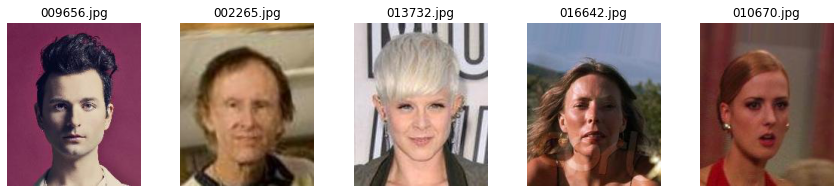

In [ ]:
visualize(DATA_PATH)

Let's define GAN. To do it, we need to define generator, discriminator and loss functions.

Here are some tips on the architecture of the generator:
1. The deeper is convolution, the less filters is using.
2. Apply deconvolutions-relu layers to achieve input image shape.
3. Use batch normalization before nonlinearity for speed and stability of learning.
4. Use tanh activation at the end of network (in this case images should be scaled to [-1, 1])
5. To force generator not to collapse and produce different outputs initialize bias with zero (see linear layer).

Other useful tips: https://github.com/soumith/ganhacks. Example of architecture see below. You may also use defined layers from ops.py. <b> Please, use names for layers started with "g\_" for generator and "d_" for discriminator.</b>

<img src="https://raw.githubusercontent.com/carpedm20/DCGAN-tensorflow/master/DCGAN.png">

## Writing generator function (1 point)

In [ ]:


def generator(z, is_training, g_bnorms):
    # Firstly let's reshape input vector into 3-d tensor. 
    
    z_ = linear(z, GENERATOR_DENSE_SIZE * 2*2, 'g_h0_lin')
    h_in = tf.reshape(z_, [-1, 2, 2, GENERATOR_DENSE_SIZE])
    
    g_bnorm_1 = g_bnorms[0](h_in, train=is_training)
    g_lrelu_1 = lrelu(g_bnorm_1,name="g_lrelu1")
    g_deconv_1 = deconv2d(g_lrelu_1,[BATCH_SIZE, 4, 4, 256],name="g_deconv1")
    
    g_bnorm_2 = g_bnorms[1](g_deconv_1, train=is_training)
    g_lrelu_2 = lrelu(g_bnorm_2,name="g_lrelu2")
    g_deconv_2 = deconv2d(g_lrelu_2,[BATCH_SIZE, 8, 8, 128],name="g_deconv2")
    
    g_bnorm_3 = g_bnorms[2](g_deconv_2, train=is_training)
    g_lrelu_3 = lrelu(g_bnorm_3,name="g_lrelu3")
    g_deconv_3 = deconv2d(g_lrelu_3,[BATCH_SIZE, 16, 16, 64],name="g_deconv3")
    
    g_bnorm_4 = g_bnorms[3](g_deconv_3, train=is_training)
    g_lrelu_4 = lrelu(g_bnorm_4,name="g_lrelu4")
    
    h_out = deconv2d(g_lrelu_4, [BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS],
            name='g_out')

    return tf.nn.tanh(h_out)

Now let's define discriminator. Discriminator takes 3d tensor as input and outputs one number - probability that this is an image.

Some advice for discriminator's architecture:
1. Use batch normalization between convolutions and nonlinearities.
2. Use leaky relu with the leak about 0.2.
3. The deeper the layer, the more filters you can use.

If you use batch normalization, please define every layer in their own scope and pass is_training parameter there. Or you may use class of batch normalization from ops.py. Do not forget to fratten tensor after the convolution blocks.

## Writing discriminator function (1 point)

In [ ]:


def discriminator(image, is_training, d_bnorms):
    
    d_conv_1 = conv2d(image, 32, name='d_conv1')
    d_bnorm_1 = d_bnorms[0](d_conv_1, train=is_training)
    d_lrelu_1 = lrelu(d_bnorm_1, name='d_lrelu1')
    
    d_conv_2 = conv2d(d_lrelu_1, 64, name='d_conv2')
    d_bnorm_2 = d_bnorms[1](d_conv_2, train=is_training)
    d_lrelu_2 = lrelu(d_bnorm_2, name='d_lrelu2')
    
    d_conv_3 = conv2d(d_lrelu_2, 128, name='d_conv3')
    d_bnorm_3 = d_bnorms[2](d_conv_3, train=is_training)
    d_lrelu_3 = lrelu(d_bnorm_3, name='d_lrelu3')
    
    d_conv_4 = conv2d(d_lrelu_3, 256, name='d_conv4')
    d_bnorm_4 = d_bnorms[3](d_conv_4, train=is_training)
    d_lrelu_4 = lrelu(d_bnorm_4, name='d_lrelu4')
    
    d_lrelu_4_flatten = tf.contrib.layers.flatten(d_lrelu_4)
    
    linear_out = linear(d_lrelu_4_flatten, 1)
    
    return tf.nn.sigmoid(linear_out), linear_out

Now let's define generator and discriminator.

In [ ]:
tf.reset_default_graph()
is_training = tf.placeholder(tf.bool, name='is_training')

with tf.variable_scope("G") as scope:
    z = tf.placeholder(tf.float32, [None, Z_DIM], name='z')
    g_bnorms = [batch_norm(name="g_bnorm1"), batch_norm(name="g_bnorm2"), batch_norm(name="g_bnorm3"), 
                batch_norm(name="g_bnorm4")]
    G = generator(z, is_training, g_bnorms)

with tf.variable_scope('D') as scope:
    images = tf.placeholder(tf.float32, shape=[None, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS])
    d_bnorms = [batch_norm(name="d_bnorm1"), batch_norm(name="d_bnorm2"), batch_norm(name="d_bnorm3"),
               batch_norm(name="d_bnorm4")]
    D_real, D_real_logits = discriminator(images, is_training, d_bnorms)
    scope.reuse_variables()
    D_fake, D_fake_logits = discriminator(G, is_training, d_bnorms)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.


Write definition of loss funstions according to formulas:
$$ D\_loss = \frac{-1}{m} \sum_{i=1}^{m}[\log{D(x_i)} + \log{(1 - D(G(z_i)))}]$$
$$ G\_loss = \frac{1}{m} \sum_{i=1}^{m} \log{(1 - D(G(z_i)))}$$

Or for better learning you may try other loss for generator:
$$ G\_loss = \frac{-1}{m} \sum_{i=1}^{m} \log{(D(G(z_i)))}$$

## Writing loss functions (2 points)

In [ ]:
"""
        You code goes here. Define discriminator and generator losses
"""
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, labels=tf.ones_like(D_real_logits)))

d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.zeros_like(D_fake_logits)))

d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.ones_like(D_fake_logits)))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Create optimizers. We use different optimizers for discriminator and generator, so we needed a separate prefix for the discriminator and generator variables (g_ for generator, d_ for disciminator).

In [ ]:
tvars = tf.trainable_variables()
## All variables of discriminator
d_vars = [v for v in tvars if 'd_' in v.name]

## All variables of generator
g_vars = [v for v in tvars if 'g_' in v.name]

LEARNING_RATE = 0.0002 # Learning rate for adam optimizer
BETA = 0.5 # Beta paramater in adam optimizer

##Optimizers - ypu may use your favourite instead.
d_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(d_loss, var_list=d_vars)
g_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(g_loss, var_list=g_vars) 

Load data:

In [ ]:
data = glob(os.path.join(DATA_PATH, "*.jpg"))[:32768]
assert(len(data) > 0), "Length of training data should be more than zero"
print(len(data))

26423


Functions for training and evaluations.

In [ ]:
def load(sess, load_dir):
    """load network's paramaters
    
    load_dir : path to load dir
    """
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(load_dir)
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)

In [ ]:
from skimage.transform import resize

def get_resize_transform_image(image_path):
    return transform(resize(plt.imread(image_path),(IMAGE_SIZE,IMAGE_SIZE,N_CHANNELS),preserve_range=True, 
                            mode='reflect', anti_aliasing=True))


In [ ]:
image_path = data[2]
c = plt.imread(image_path)
print(c.shape)
d = get_resize_transform_image(image_path)
print(d.shape)

(218, 178, 3)
(32, 32, 3)


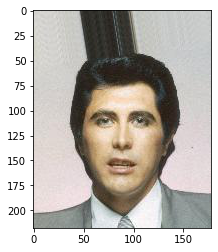

In [ ]:
plt.imshow(c)

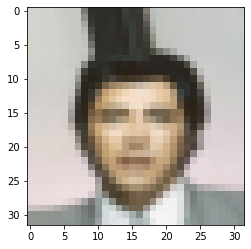

In [ ]:
plt.imshow(inverse_transform(d))

## Training GAN (1 point + 2 for good results)

In [ ]:
def train(sess, load_dir=None, save_frequency=600, sample_frequency=64, sample_dir='sample_faces',
          save_dir='checkpoint', max_to_keep=1, model_name='dcgan.model',
          n_epochs=2, n_generator_update=2):
    """train gan
    Parameters
    -------------------------------------------
    load_dir : str, default = None
        path to the folder with parameters
    save_frequency: int, default = 100
        how often save parameters []
    sample_frequency: int, default = None (not sample)
        how often sample faces
    sample_dir: str, default = samples
        directory for sampled images
    save_dir: str, default = 'checkpoint'
        path where to save parameters
    max_to_keep: int, default = 1
        how many last checkpoints to store
    model_name: str, default='dcgan.model'
        name of model
    n_epochs: int, default = 25 
        number epochs to train
    n_generator_update: int, default = 2
        how many times run generator updates per one discriminator update
    -------------------------------------------
    """
    
    if save_frequency is not None:
        saver = tf.train.Saver(max_to_keep=max_to_keep)
        
    if load_dir is not None:
        print("Reading checkpoints...")
        load(sess, load_dir)
        print("Loaded checkpoints")
    else:
        try:
            tf.global_variables_initializer().run()
        except:
            tf.initialize_all_variables().run()

    counter=1
    start_time = time.time()
    
    for epoch in range(n_epochs):
        batch_idxs = min(len(data), np.inf) // BATCH_SIZE
        for idx in range(0, batch_idxs):
            batch_files = data[idx*BATCH_SIZE:(idx+1)*BATCH_SIZE]
            batch = [get_resize_transform_image(batch_file) for batch_file in batch_files]
            batch_images = np.array(batch).astype(np.float32)
            batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)

            # Update D network
            sess.run(d_optim, feed_dict={images: batch_images, z: batch_z,is_training: True})

            # Update G network
            for _ in range(n_generator_update):
                sess.run(g_optim,
                    feed_dict={z: batch_z, is_training: True})

            errD_fake = d_loss_fake.eval({z: batch_z, is_training: False})
            errD_real = d_loss_real.eval({images: batch_images, is_training: False})
            errG = g_loss.eval({z: batch_z, is_training: False})

            counter += 1
            print("Epoch: [{:2d}] [{:4d}/{:4d}] time: {:4.4f}, d_loss: {:.8f}, g_loss: {:.8f}".format(
                epoch, idx, batch_idxs, time.time() - start_time, errD_fake+errD_real, errG))

            if np.mod(counter, save_frequency) == 1:
                print("Saved model")
                saver.save(sess, os.path.join(save_dir, model_name))

            if np.mod(counter, sample_frequency) == 1:
                samples = sess.run(G, feed_dict={z: batch_z, is_training: False} )
                save_images(samples[:MERGE_X*MERGE_Y], [MERGE_X, MERGE_Y],
                            os.path.join(sample_dir, 'train_{:02d}_{:04d}.png'.format(epoch, idx)))
                print("Sample")

If you generated something that looks like a face - it's cool! Add 2 points to your mark.

In [24]:
with tf.Session() as sess:
    train(sess, save_dir='checkpoint')

Epoch: [ 0] [   0/ 412] time: 32.5932, d_loss: 1.37992024, g_loss: 0.68785197
Epoch: [ 0] [   1/ 412] time: 63.8026, d_loss: 1.37139583, g_loss: 0.69676965
Epoch: [ 0] [   2/ 412] time: 93.8733, d_loss: 1.36448956, g_loss: 0.72717118
Epoch: [ 0] [   3/ 412] time: 125.9345, d_loss: 1.36027551, g_loss: 0.77955532
Epoch: [ 0] [   4/ 412] time: 156.7911, d_loss: 1.36374307, g_loss: 0.84044111
Epoch: [ 0] [   5/ 412] time: 187.3055, d_loss: 1.37793279, g_loss: 0.87883490
Epoch: [ 0] [   6/ 412] time: 217.9879, d_loss: 1.40375543, g_loss: 0.89130712
Epoch: [ 0] [   7/ 412] time: 249.3884, d_loss: 1.42436886, g_loss: 0.90547365
Epoch: [ 0] [   8/ 412] time: 279.1561, d_loss: 1.47753525, g_loss: 0.87578803
Epoch: [ 0] [   9/ 412] time: 310.0579, d_loss: 1.58397913, g_loss: 0.81844592
Epoch: [ 0] [  10/ 412] time: 342.8240, d_loss: 1.67555666, g_loss: 0.73133600
Epoch: [ 0] [  11/ 412] time: 374.1709, d_loss: 1.71101093, g_loss: 0.64247936
Epoch: [ 0] [  12/ 412] time: 403.8878, d_loss: 1.77810

In [25]:
sess=tf.Session()
load(sess, load_dir='checkpoint') #load weights from training of about 13 epoches

INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model


In [27]:
#init = tf.global_variables_initializer()
new_samples = 10 # 10 batches
counter = 0
new_samples_dir = 'sample_faces'
for idx in range(new_samples):    
    batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
    samples = sess.run(G, feed_dict={z: batch_z, is_training: False})
    for sample in samples:
        plt.imsave(os.path.join(new_samples_dir, 'sample_'+str(counter)+'.jpg'), (255*inverse_transform(sample)).astype(np.uint8))
        counter += 1

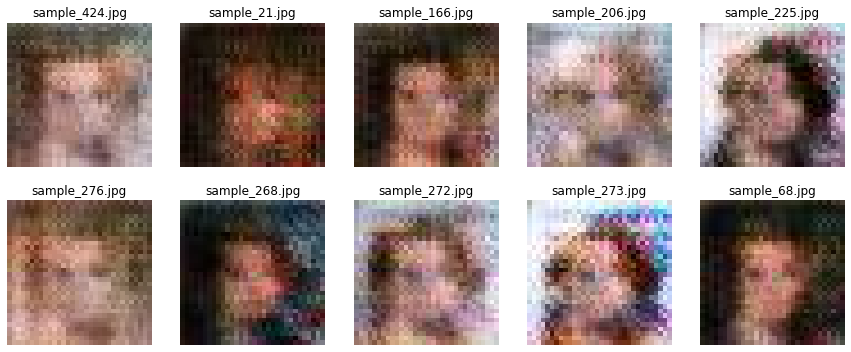

In [28]:
visualize(new_samples_dir, n_cols=5, n_rows=2)

## Face interpolation (1 point)

Let's interpolate between faces: generate two vectors $z_1$ and $z_2$ and get a batch of vectors of the form $\alpha\cdot z_1 + (1- \alpha)\cdot  z_2, \alpha \in [0,1].$ Generate faces on them and look at results. The generator displays pictures in the range from -1 to 1, so use the inverse transform function from the file utils.py.

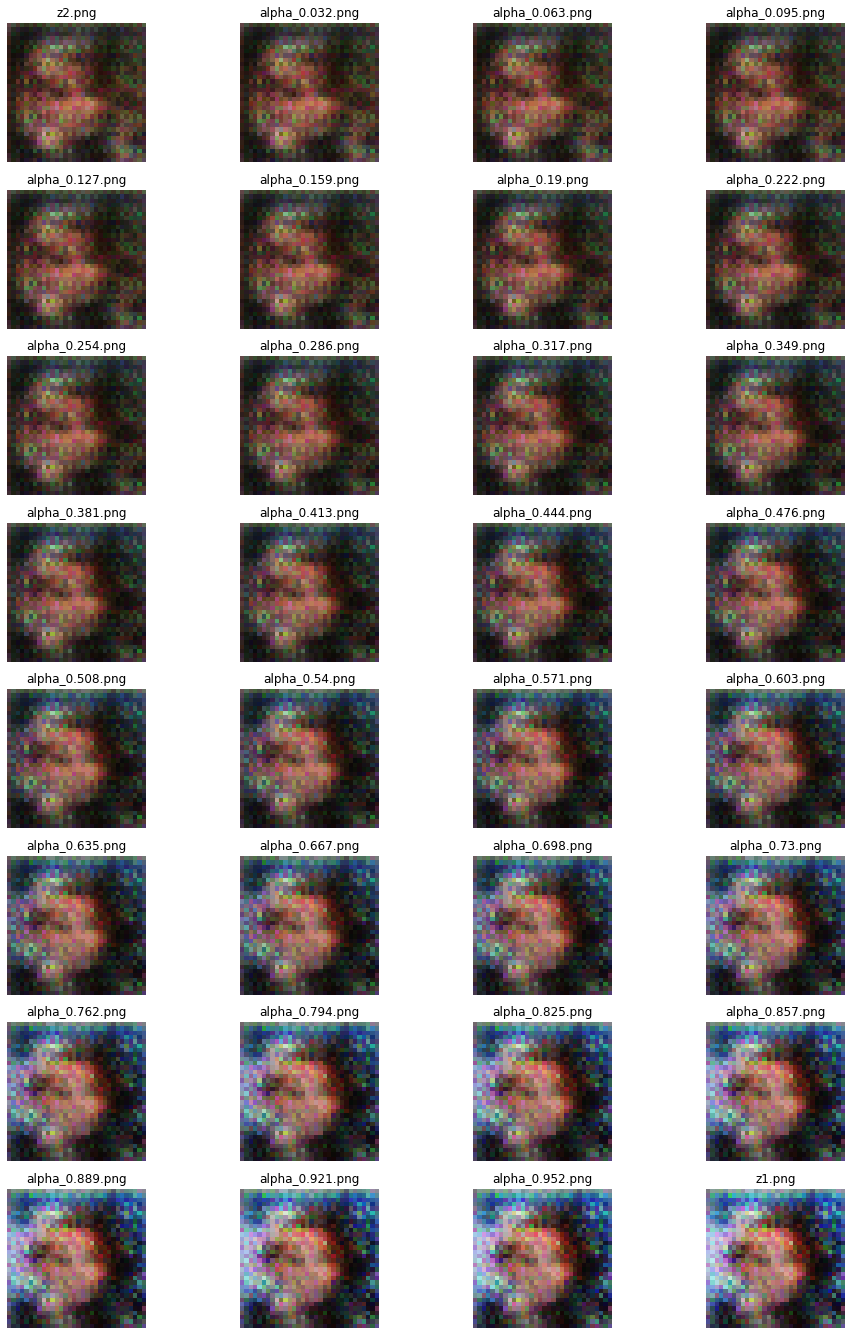

In [30]:
zs = np.random.uniform(-1, 1, [2, Z_DIM]).astype(np.float32)
alphas = np.linspace(0, 1, BATCH_SIZE)
batchz = np.zeros((BATCH_SIZE, Z_DIM))
for i, alpha in enumerate(alphas):
    batchz[i] = alpha*zs[0] + (1 - alpha)*zs[1]
samples = sess.run(G, feed_dict={z: batchz, is_training: False})
interpolation_dir = 'face_interpolation'
names = []
for i, sample in enumerate(samples):
    if i == 0:
        filename = 'z2.png'
        names.append(filename)
    elif i == len(samples) - 1:
        filename = 'z1.png'
        names.append(filename)
    else:
        filename = 'alpha_' + str(round(alphas[i], 3)) + '.png'
        if i&1 == 0 and i != len(samples) - 2:
            names.append(filename)
    plt.imsave(os.path.join(interpolation_dir, filename), (255*inverse_transform(sample)).astype(np.uint8))

plt.figure(figsize=(16, 24))
for i, name in enumerate(names):
    plt.subplot(8, 4, i+1)
    plt.axis('off')
    img = plt.imread(join(interpolation_dir, name))
    plt.imshow(img)
    plt.title(name)
plt.show()

When alpha increases from 0 to 1, z2 image becomes to z1 image.

## Adding a smile (1 point + 1 point for good results)

Let's make face smiling. Find several vectors z, such that the generator generates smiling faces and not. Five vectors in every group should be enough (but the more, the better).

Calculate "smile vector" as mean of vectors z with generated smile on it minus mean of vectors z with generated not smile on it.

Look at the result of applying the smile vector: compare the results of generation before and after the addition of the smile vector.

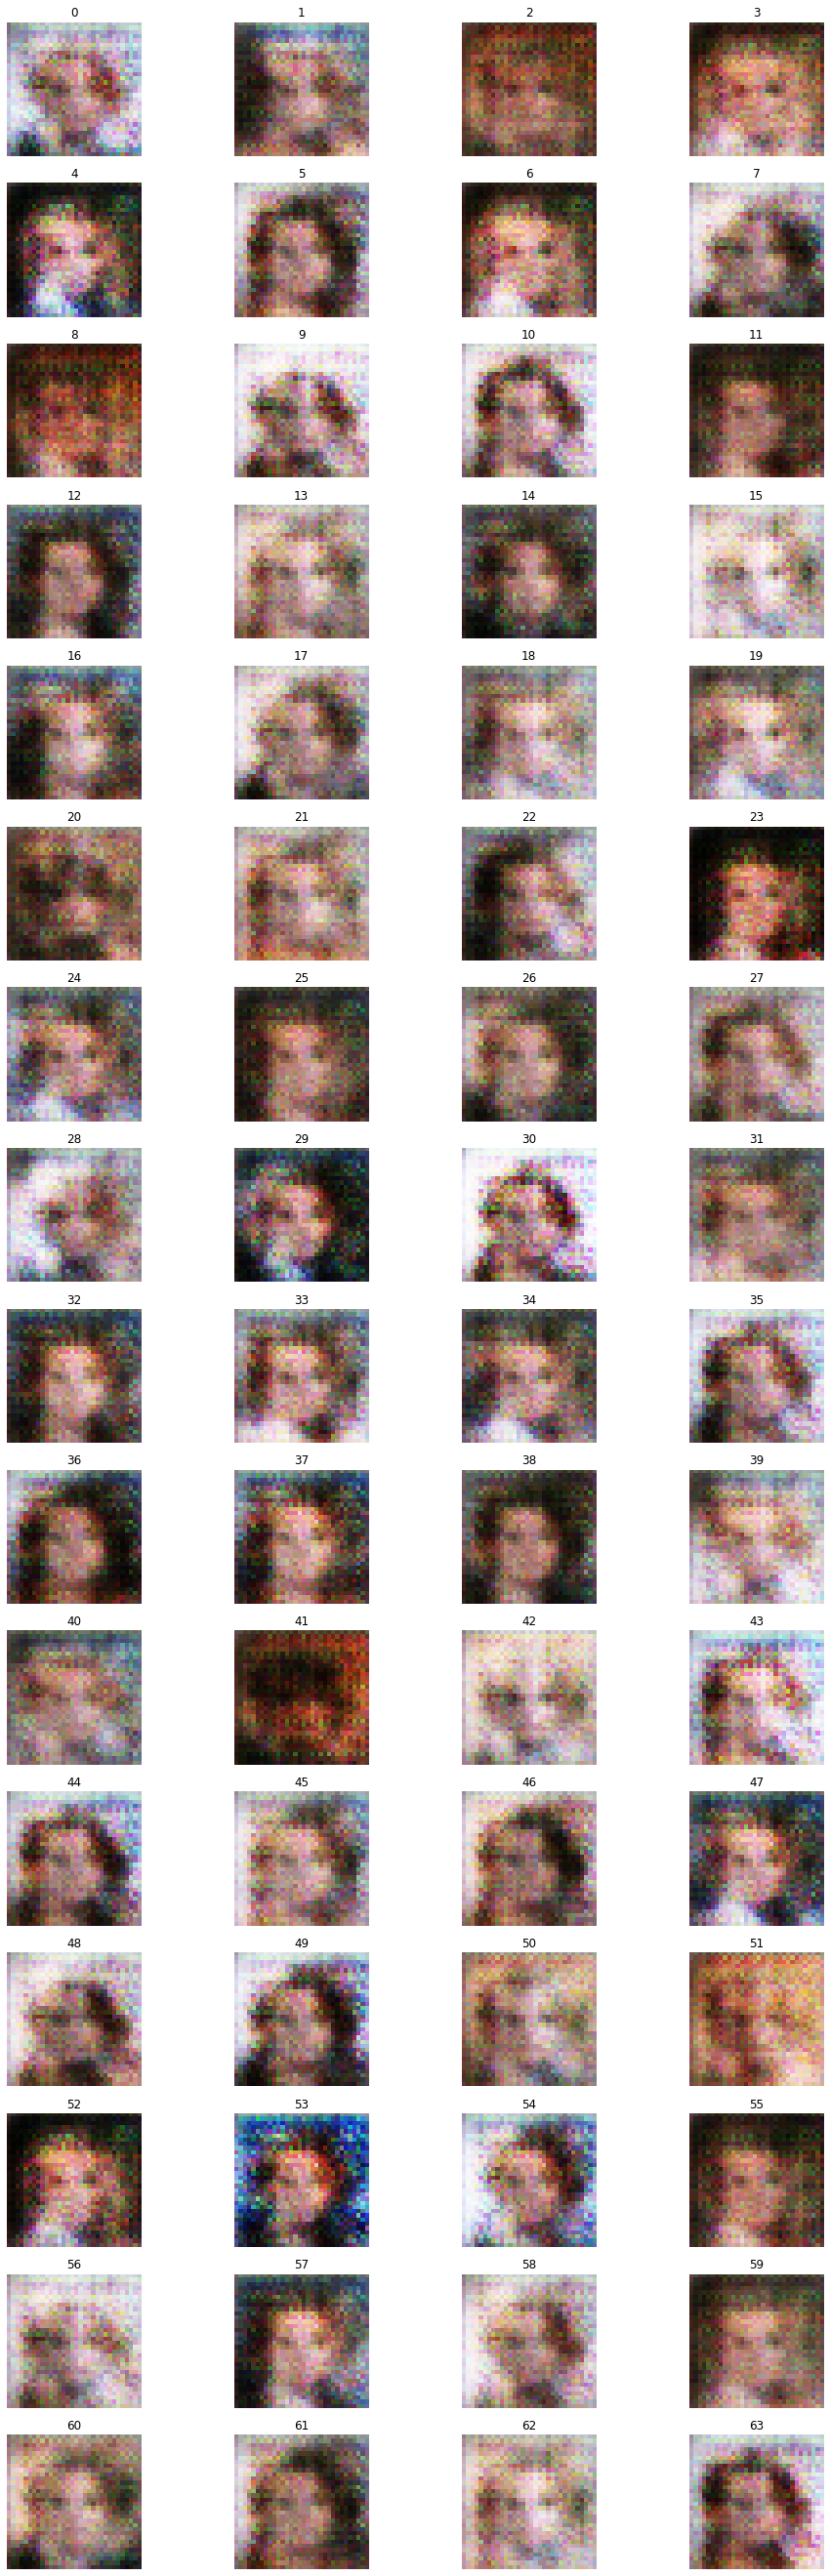

In [31]:
batchz = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
samples = sess.run(G, feed_dict={z: batchz, is_training: False})
plt.figure(figsize=(16, 48))
for i, sample in enumerate(samples):
    plt.subplot(16, 4, i+1)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow((255*inverse_transform(sample)).astype(np.uint8))
plt.show()

Manually classify images with smile and without smile.

In [32]:
with_smiles = [1, 4, 5, 7, 8, 10, 19, 36, 37, 43, 47, 57, 61, 63]
without_smiles = [3, 11, 13, 15, 16, 27, 46, 60]
with_smile_mean = batchz[with_smiles].mean(axis=0)
without_smile_mean = batchz[without_smiles].mean(axis=0)

smile_vector = with_smile_mean - without_smile_mean

add_smile = batchz + smile_vector
add_smile = add_smile.clip(-1, 1)
add_smile_samples = sess.run(G, feed_dict={z: add_smile, is_training: False})

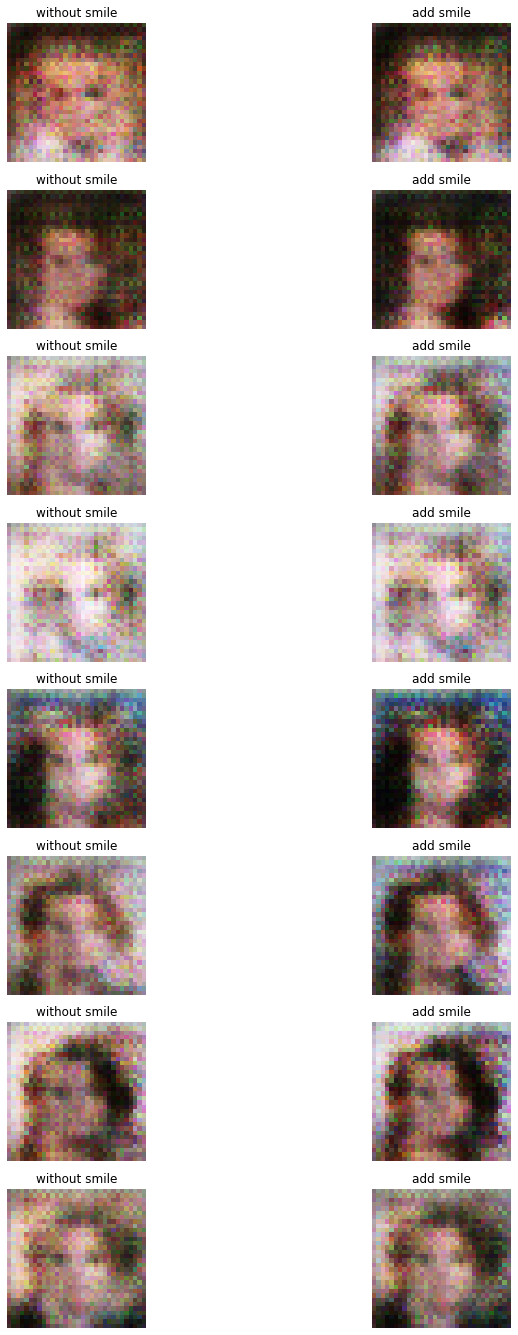

In [35]:
plt.figure(figsize = (12, 24))
for i, idx in enumerate(without_smiles):
    plt.subplot(len(without_smiles), 2, i*2+1)
    plt.axis('off')
    plt.title("without smile")
    plt.imshow((255*inverse_transform(samples[idx])).astype(np.uint8))
    plt.subplot(len(without_smiles), 2, i*2+2)
    plt.axis('off')
    plt.title("add smile")
    plt.imshow((255*inverse_transform(add_smile_samples[idx])).astype(np.uint8))
plt.show()

If faces looks really cool, add bonus 1 point to your score.